# **Hotspot tutorial: Transcriptional Patterns in CD4 T Cells**

In [1]:
import harreman
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import mplscience
from scipy.stats import pearsonr, spearmanr, gaussian_kde
import random
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def corr_plot(x, y, mean_expr, max_num=10000, outlier=0.01, line_on=True, method='spearman',
              legend_on=True, size=30, dot_color=None, outlier_color="r",
              alpha=0.8, color_rate=10, corr_on=None, colorbar=True, pmax=95, pmin=5):

    if method == 'pearson':
        score = pearsonr(x, y)
    if method == 'spearman':
        score = spearmanr(x, y)
    np.random.seed(0)
    if len(x) > max_num:
        idx = np.random.permutation(len(x))[:max_num]
        x, y = x[idx], y[idx]
        mean_expr = mean_expr[idx]
    outlier = int(len(x) * outlier)

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    idx1, idx2 = idx[outlier:], idx[:outlier]

    if dot_color is None:
        # c_score = np.log2(z[idx] + color_rate * np.min(z[idx]))
        c_score = mean_expr
    else:
        c_score = dot_color

    plt.set_cmap("Blues")
    vmax = np.percentile(c_score, pmax)
    vmin = np.percentile(c_score, pmin)
    plt.scatter(x, y, c=c_score, edgecolor=None, s=size, alpha=alpha, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar()
    # plt.scatter(x[idx2], y[idx2], c=outlier_color, edgecolor=None, s=size / 5,
    #             alpha=alpha / 3.0)

    if line_on:
        clf = linear_model.LinearRegression()
        clf.fit(x.reshape(-1, 1), y)
        xx = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        yy = clf.predict(xx)
        plt.plot(xx, yy, "k--", label="R=%.3f" % score[0])

    if legend_on or corr_on:
        plt.legend(loc="best", fancybox=True, ncol=1)

## Transcriptional Patterns in CD4 T Cells

In [19]:
mdata = mu.read_10x_h5(os.path.join(HOTSPOT_TUTO_DATA, "5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"))

In [20]:
mdata.var_names_make_unique()

In [21]:
adata = mdata.mod["rna"]

In [22]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

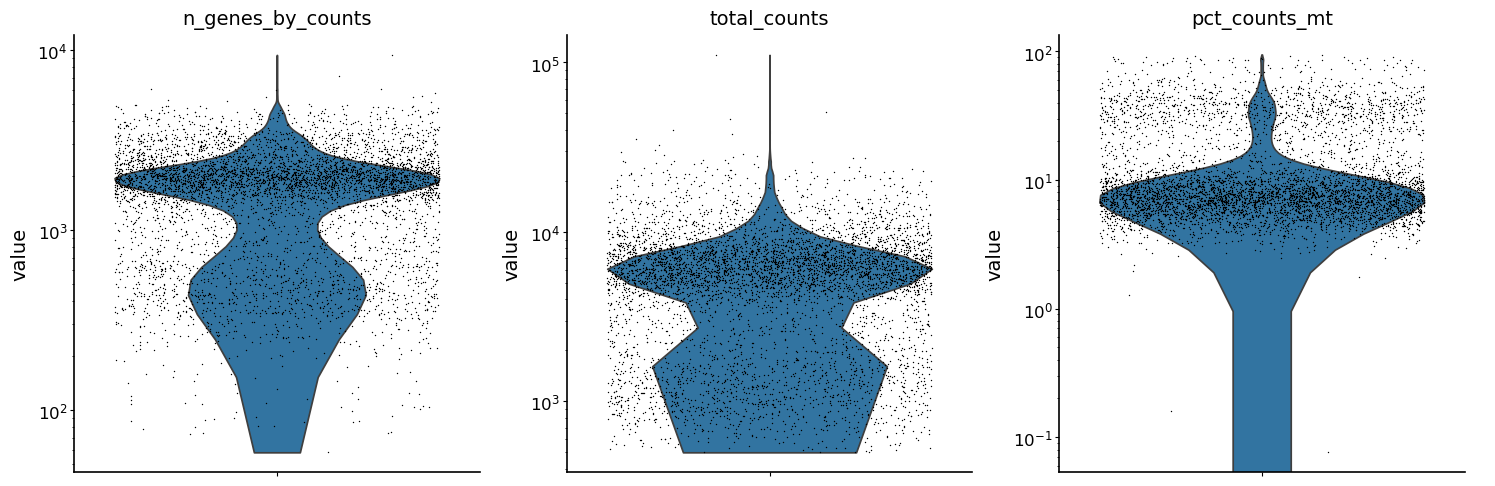

In [23]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True, log=True)

In [24]:
from muon import prot as pt
pt.pp.clr(mdata['prot'])

prot_data = mdata.mod["prot"]

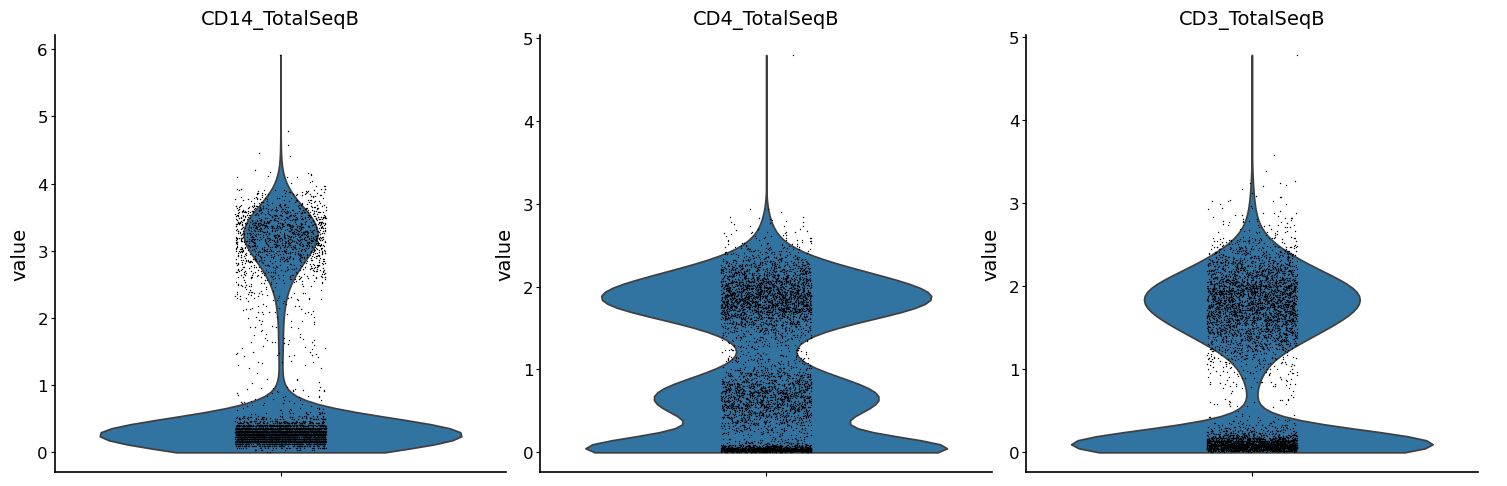

In [25]:
with mplscience.style_context():
    sc.pl.violin(prot_data, keys=["CD14_TotalSeqB", "CD4_TotalSeqB", "CD3_TotalSeqB"], multi_panel=True)

In [26]:
# now create a CD4 T cell mask
is_cd4 = np.asarray(
    (prot_data[:, 'CD14_TotalSeqB'].X.A < 2) &
    (prot_data[:, 'CD4_TotalSeqB'].X.A > 1) &
    (prot_data[:, 'CD3_TotalSeqB'].X.A > 1)
).ravel()

adata_cd4 = adata[is_cd4]
sc.pp.filter_cells(adata_cd4, min_genes=1000)
sc.pp.filter_genes(adata_cd4, min_cells=10)
adata_cd4 = adata_cd4[adata_cd4.obs.pct_counts_mt < 16].copy()

adata_cd4

AnnData object with n_obs × n_vars = 1547 × 12456
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [27]:
adata_cd4.layers["counts"] = adata_cd4.X.copy()
sc.pp.normalize_total(adata_cd4)
sc.pp.log1p(adata_cd4)
adata_cd4.layers["log_normalized"] = adata_cd4.X.copy()
sc.pp.scale(adata_cd4)
sc.tl.pca(adata_cd4)

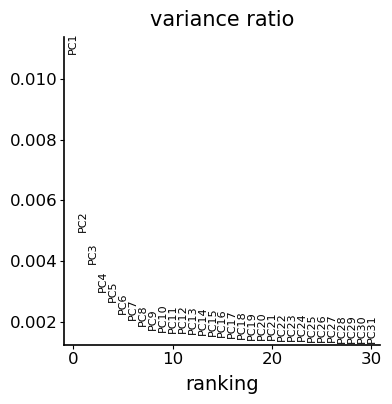

In [28]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata_cd4)

In [29]:
# rerun with fewer components
sc.tl.pca(adata_cd4, n_comps=10)

### Running the optimized Hotspot version

In [30]:
adata_cd4.layers["counts_csc"] = adata_cd4.layers["counts"].tocsc()

In [31]:
harreman.tl.compute_knn_graph(adata_cd4, 
                           compute_neighbors_on_key="X_pca", 
                           n_neighbors=30,
                           weighted_graph=False,
                           verbose=True)

Computing the neighborhood graph...
Computing the weights...
Finished computing the KNN graph in 0.050 seconds


In [32]:
# harreman.hs.compute_local_autocorrelation(adata_cd4, layer_key="counts_csc", model='danb', umi_counts_obs_key="total_counts")
harreman.hs.compute_local_autocorrelation(adata_cd4, layer_key="counts_csc", model='danb', umi_counts_obs_key="total_counts", permutation_test=True)

Permutation test: 100%|██████████| 1000/1000 [00:22<00:00, 44.52it/s]


Text(0.5, 1.0, 'Autocorrelation p-value (Permutation vs Z-Score)')

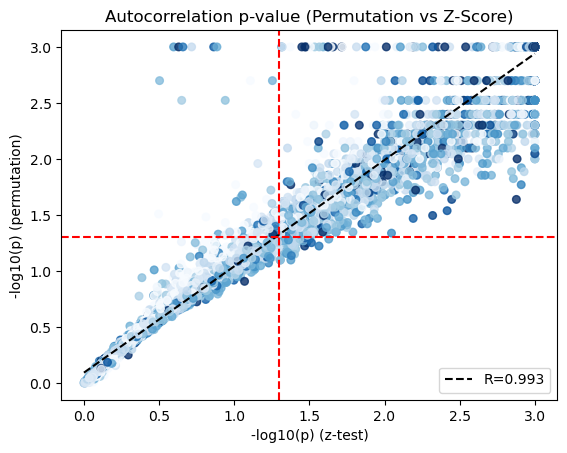

In [33]:
# global consistency
x = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata_cd4.uns['gene_autocorrelation_results'].index
# mean_expr = adata_cd4[:,genes].layers['log_normalized'].mean(axis=0).A1

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')

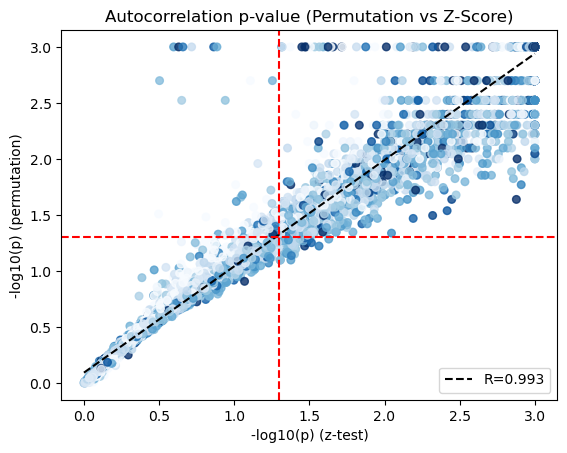

In [34]:
# global consistency
x = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata_cd4.uns['gene_autocorrelation_results'].index
# mean_expr = adata_cd4[:,genes].layers['log_normalized'].mean(axis=0).A1

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'CD4_p_np_autocorrelation_plot.pdf'))

In [36]:
hs_results = adata_cd4.uns['gene_autocorrelation_results']
hs_genes = hs_results.loc[hs_results.Z_FDR < 0.05].sort_values('Z', ascending=False).head(500).index

In [37]:
# harreman.hs.compute_local_correlation(adata_cd4, genes=hs_genes)
harreman.hs.compute_local_correlation(adata_cd4, genes=hs_genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 500 features...


Permutation test:   0%|          | 0/1000 [00:00<?, ?it/s]

Permutation test: 100%|██████████| 1000/1000 [00:06<00:00, 156.02it/s]

Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 6.520 seconds


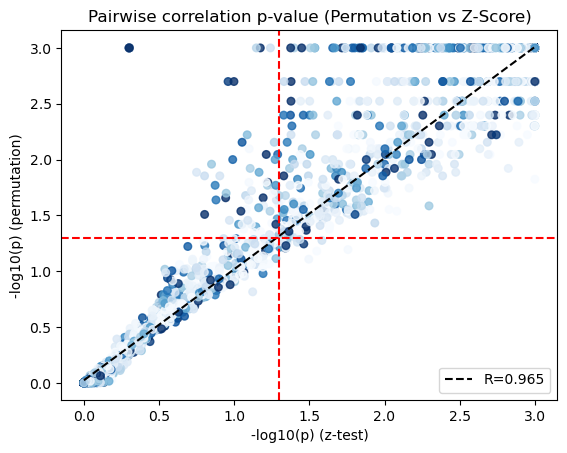

In [39]:
# global consistency
x = -np.log10(adata_cd4.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata_cd4.uns['lc_perm_pvals'].values).flatten()

genes = adata_cd4.uns['lc_z_pvals'].index
# mean_expr = adata_cd4[:,genes].layers['log_normalized'].mean(axis=0).A1

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts

mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'CD4_p_np_correlation_plot.pdf'))

In [40]:
harreman.hs.create_modules(adata_cd4, min_gene_threshold=15, core_only=True, fdr_threshold=0.05)

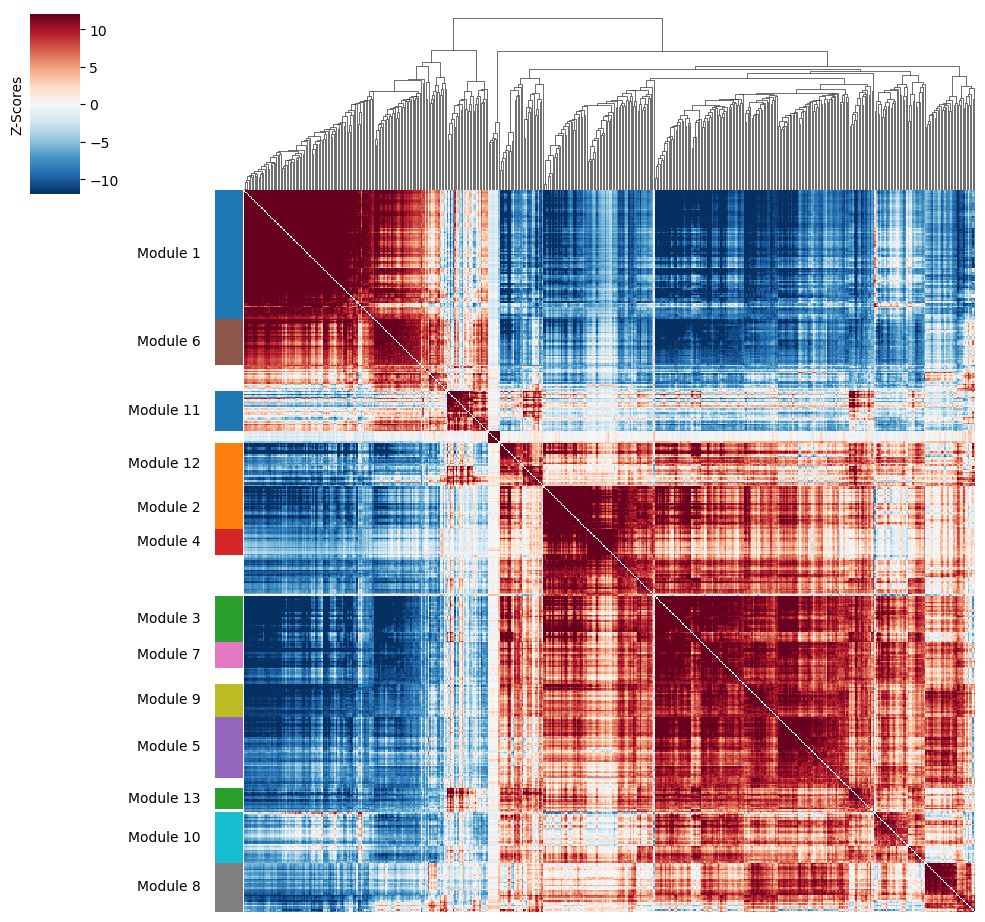

In [41]:
harreman.pl.local_correlation_plot(adata_cd4, vmin=-12, vmax=12)

In [42]:
harreman.hs.calculate_module_scores(adata_cd4)

100%|██████████| 13/13 [00:00<00:00, 35.99it/s]


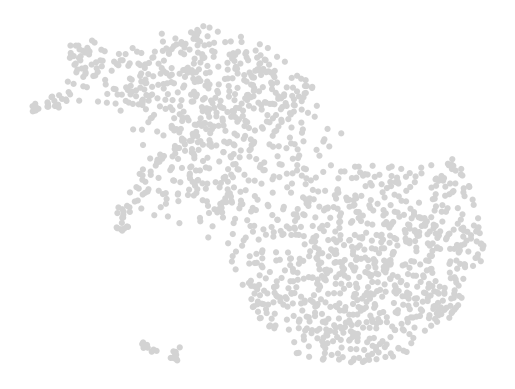

In [43]:
sc.pp.neighbors(adata_cd4)
sc.tl.umap(adata_cd4)
sc.pl.umap(adata_cd4, frameon=False)

In [44]:
modules = adata_cd4.obsm['module_scores'].columns
adata_cd4.obs[modules] = adata_cd4.obsm['module_scores']

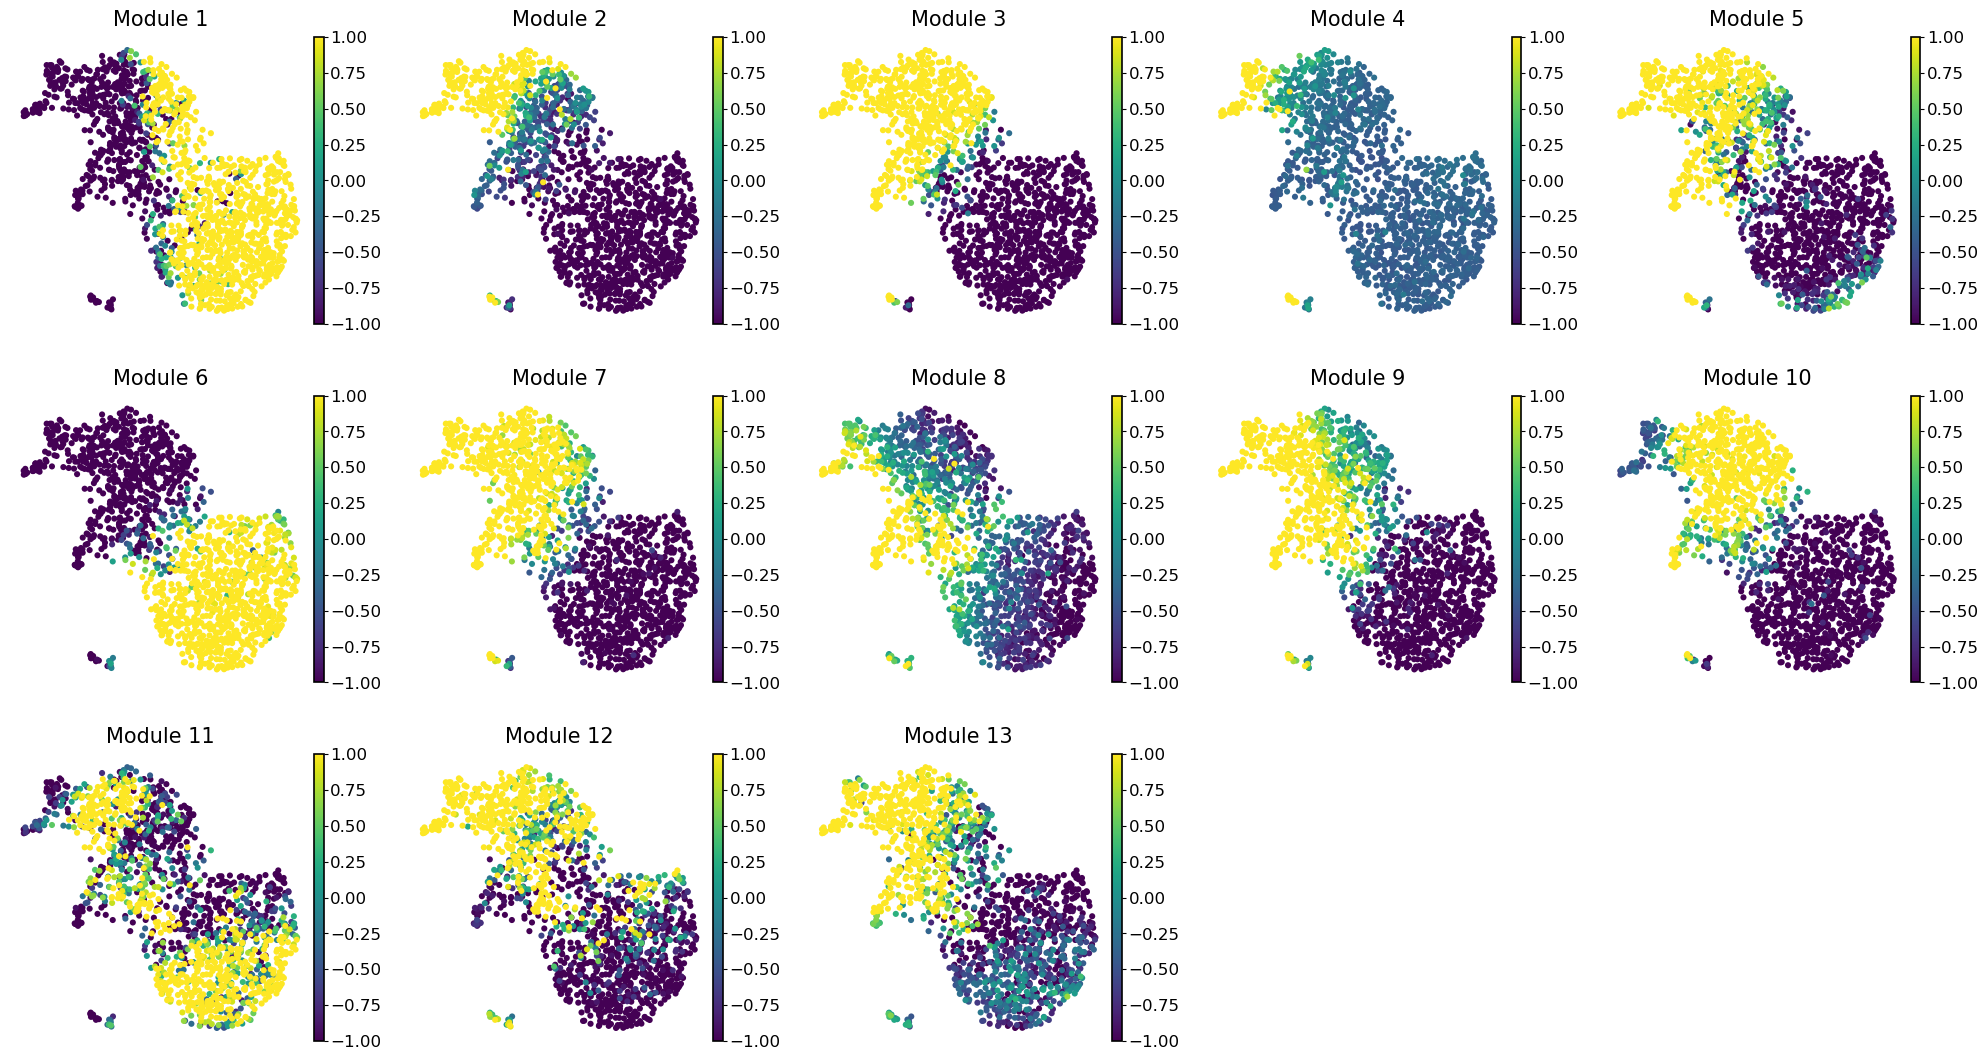

In [46]:
with mplscience.style_context():
    sc.pl.umap(adata_cd4, color=modules, frameon=False, vmin="-1", vmax="1", ncols=5, cmap='viridis')